In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from pprint import pformat

from hloc import (
    extract_features,
    match_features,
    pairs_from_covisibility,
    pairs_from_retrieval,
)
from hloc import colmap_from_nvm, triangulation, localize_sfm, visualization

# Pipeline for outdoor day-night visual localization

## Setup
Here we declare the paths to the dataset, the reconstruction and localization outputs, and we choose the feature extractor and the matcher. You only need to download the [Aachen Day-Night dataset](https://www.visuallocalization.net/datasets/) and put it in `datasets/aachen/`, or change the path.

In [2]:
dataset = Path("datasets/aachen/")  # change this if your dataset is somewhere else
images = dataset / "images_upright/"

outputs = Path("outputs/aachen/")  # where everything will be saved
sfm_pairs = outputs / "pairs-db-covis20.txt"  # top 20 most covisible in SIFT model
loc_pairs = outputs / "pairs-query-netvlad20.txt"  # top 20 retrieved by NetVLAD
reference_sfm = outputs / "sfm_superpoint+superglue"  # the SfM model we will build
results = outputs / "Aachen_hloc_superpoint+superglue_netvlad20.txt"  # the result file

# list the standard configurations available
# print(f"Configs for feature extractors:\n{pformat(extract_features.confs)}")
# print(f"Configs for feature matchers:\n{pformat(match_features.confs)}")

In [3]:
# pick one of the configurations for image retrieval, local feature extraction, and matching
# you can also simply write your own here!
retrieval_conf = extract_features.confs["netvlad"]
feature_conf = extract_features.confs["superpoint_aachen"]
matcher_conf = match_features.confs["superglue"]

## Extract local features for database and query images

In [ ]:
# check torch gpu on
if not torch.cuda.is_available():
    raise Exception("Check torch + GPU status")

In [4]:
features = extract_features.main(feature_conf, images, outputs)

[2024/02/29 17:06:11 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}
[2024/02/29 17:06:11 hloc INFO] Found 5426 images in root datasets/aachen/images_upright.


Loaded SuperPoint model


100%|█████████████████████████████████████████████████████████████████████████████████████| 5426/5426 [04:35<00:00, 19.70it/s]
[2024/02/29 17:10:47 hloc INFO] Finished exporting features.


The function returns the path of the file in which all the extracted features are stored.

## Generate pairs for the SfM reconstruction
Instead of matching all database images exhaustively, we exploit the existing SIFT model to find which image pairs are the most covisible. We first convert the SIFT model from the NVM to the COLMAP format, and then do a covisiblity search, selecting the top 20 most covisibile neighbors for each image.

In [5]:
# set into colmap object
colmap_from_nvm.main(
    dataset / "3D-models/aachen_cvpr2018_db.nvm",
    dataset / "3D-models/database_intrinsics.txt",
    dataset / "aachen.db",
    outputs / "sfm_sift",
)

[2024/02/29 17:19:20 hloc INFO] Found 13026 images and 13026 cameras in database.
[2024/02/29 17:19:20 hloc INFO] Reading the NVM model...
[2024/02/29 17:19:20 hloc INFO] Reading 4328 cameras...
[2024/02/29 17:19:20 hloc INFO] Reading 4328 images...
[2024/02/29 17:19:20 hloc INFO] Reading 1652687 points...
100%|███████████████████████████████████████████████████████████████████████████| 1652687/1652687 [00:23<00:00, 70309.75pts/s]
[2024/02/29 17:19:43 hloc INFO] Parsing image data...
[2024/02/29 17:19:59 hloc INFO] Writing the COLMAP model...
[2024/02/29 17:21:06 hloc INFO] Done.
[2024/02/29 17:21:07 hloc INFO] Reading the COLMAP model...
[2024/02/29 17:21:31 hloc INFO] Extracting image pairs from covisibility info...
100%|████████████████████████████████████████████████████████████████████████████████████| 4328/4328 [00:39<00:00, 110.41it/s]
[2024/02/29 17:22:10 hloc INFO] Found 85515 pairs.


In [ ]:
# find pairs
pairs_from_covisibility.main(outputs / "sfm_sift", sfm_pairs, num_matched=20)

## Match the database images

In [6]:
sfm_matches = match_features.main(
    matcher_conf, sfm_pairs, feature_conf["output"], outputs
)

[2024/02/29 17:32:43 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


100%|████████████████████████████████████████████████████████████████████████████████| 56717/56717 [10:18:44<00:00,  1.53it/s]
[2024/03/01 03:51:27 hloc INFO] Finished exporting matches.


The function returns the path of the file in which all the computed matches are stored.

## Triangulate a new SfM model from the given poses
We triangulate the sparse 3D pointcloud given the matches and the reference poses stored in the SIFT COLMAP model.

In [7]:
reconstruction = triangulation.main(
    reference_sfm, outputs / "sfm_sift", images, sfm_pairs, features, sfm_matches
)

[2024/03/01 13:00:47 hloc INFO] Importing features into the database...
100%|███████████████████████████████████████████████████████████████████████████████████| 4328/4328 [00:02<00:00, 1965.88it/s]
[2024/03/01 13:00:49 hloc INFO] Importing matches into the database...
100%|█████████████████████████████████████████████████████████████████████████████████| 85515/85515 [00:35<00:00, 2440.64it/s]
[2024/03/01 13:01:25 hloc INFO] Performing geometric verification of the matches...
100%|█████████████████████████████████████████████████████████████████████████████████████| 4328/4328 [05:10<00:00, 13.94it/s]
[2024/03/01 13:06:35 hloc INFO] mean/med/min/max valid matches 90.35/98.65/0.00/100.00%.
[2024/03/01 13:06:35 hloc INFO] Running 3D triangulation...
I20240301 13:06:35.623319 981624 misc.cc:198] 
Loading database
I20240301 13:06:35.632767 981624 database_cache.cc:54] Loading cameras...
I20240301 13:06:35.634223 981624 database_cache.cc:64]  4328 in 0.001s
I20240301 13:06:35.634239 981624 d

## Find image pairs via image retrieval
We extract global descriptors with NetVLAD and find for each image the $k$ most similar ones. A larger $k$ improves the robustness of the localization for difficult queries but makes the matching more expensive. Using $k{=}10{-}20$ is generally a good tradeoff but $k{=}50$ gives the best results for the Aachen Day-Night dataset.

In [8]:
global_descriptors = extract_features.main(retrieval_conf, images, outputs)
pairs_from_retrieval.main(
    global_descriptors, loc_pairs, num_matched=20, db_prefix="db", query_prefix="query"
)

[2024/03/01 13:17:34 hloc INFO] Extracting local features with configuration:
{'model': {'name': 'netvlad'},
 'output': 'global-feats-netvlad',
 'preprocessing': {'resize_max': 1024}}
[2024/03/01 13:17:34 hloc INFO] Found 5426 images in root datasets/aachen/images_upright.
100%|██████████████████████████████████████████████████████████████████████████████████████| 529M/529M [00:51<00:00, 10.8MB/s]
100%|█████████████████████████████████████████████████████████████████████████████████████| 5426/5426 [11:45<00:00,  7.69it/s]
[2024/03/01 13:30:17 hloc INFO] Finished exporting features.
[2024/03/01 13:30:17 hloc INFO] Extracting image pairs from a retrieval database.
[2024/03/01 13:30:22 hloc INFO] Found 18940 pairs.


## Match the query images

In [9]:
loc_matches = match_features.main(
    matcher_conf, loc_pairs, feature_conf["output"], outputs
)

[2024/03/01 15:26:45 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


100%|█████████████████████████████████████████████████████████████████████████████████| 18940/18940 [3:30:37<00:00,  1.50it/s]
[2024/03/01 18:57:23 hloc INFO] Finished exporting matches.


## Localize!
Perform hierarchical localization using the precomputed retrieval and matches. The file `Aachen_hloc_superpoint+superglue_netvlad50.txt` will contain the estimated query poses. Have a look at `Aachen_hloc_superpoint+superglue_netvlad50.txt_logs.pkl` to analyze some statistics and find failure cases.

In [10]:
localize_sfm.main(
    reconstruction,
    dataset / "queries/*_time_queries_with_intrinsics.txt",
    loc_pairs,
    features,
    loc_matches,
    results,
    covisibility_clustering=False,
)  # not required with SuperPoint+SuperGlue

[2024/03/04 15:04:17 hloc.utils.parsers INFO] Imported 98 images from night_time_queries_with_intrinsics.txt
[2024/03/04 15:04:17 hloc.utils.parsers INFO] Imported 824 images from day_time_queries_with_intrinsics.txt
[2024/03/04 15:04:17 hloc INFO] Reading the 3D model...
[2024/03/04 15:04:17 hloc INFO] Starting localization...
  8%|██████▊                                                                                 | 72/922 [00:15<03:17,  4.30it/s][2024/03/04 15:04:33 hloc WARNING] Image db/3940.jpg was retrieved but not in database
[2024/03/04 15:04:33 hloc WARNING] Image db/3807.jpg was retrieved but not in database
 14%|███████████▉                                                                           | 127/922 [00:28<03:28,  3.81it/s][2024/03/04 15:04:46 hloc WARNING] Image db/2395.jpg was retrieved but not in database
[2024/03/04 15:04:46 hloc WARNING] Image db/2402.jpg was retrieved but not in database
 15%|████████████▉                                                    

## Visualizing the SfM model
We visualize some of the database images with their detected keypoints.

Color the keypoints by track length: red keypoints are observed many times, blue keypoints few.

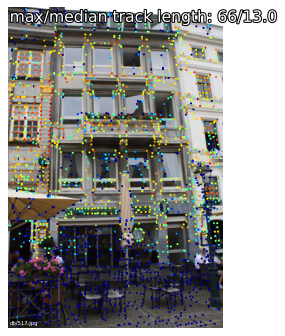

In [11]:
visualization.visualize_sfm_2d(reconstruction, images, n=1, color_by="track_length")

Color the keypoints by visibility: blue if sucessfully triangulated, red if never matched.

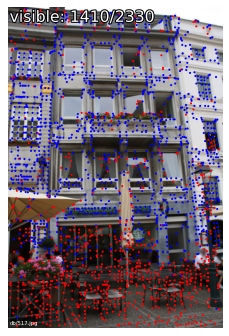

In [13]:
visualization.visualize_sfm_2d(reconstruction, images, n=1, color_by="visibility")

Color the keypoints by triangulated depth: red keypoints are far away, blue keypoints are closer.

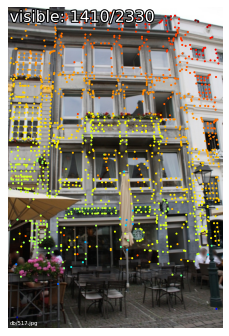

In [14]:
visualization.visualize_sfm_2d(reconstruction, images, n=1, color_by="depth")

## Visualizing the localization
We parse the localization logs and for each query image plot matches and inliers with a few database images.

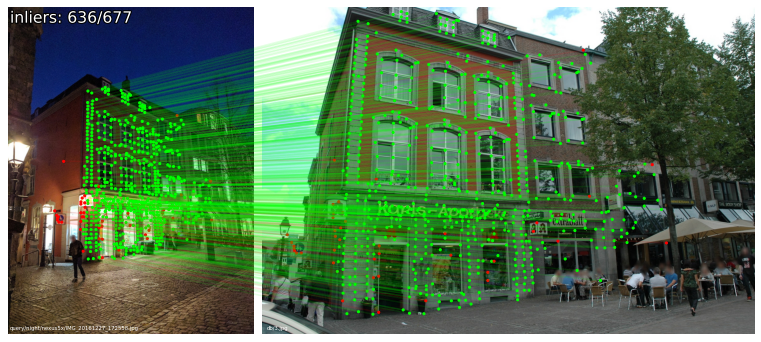

In [15]:
visualization.visualize_loc(
    results, images, reconstruction, n=1, top_k_db=1, prefix="query/night", seed=2
)

In [18]:
import torch

print(torch.cuda.memory_allocated())  
print(torch.cuda.memory_reserved())
torch.cuda.empty_cache()

8519680
178257920
